<a href="https://colab.research.google.com/github/Vaycold/statistics_seminar/blob/main/covid19_tweet/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
import re

warnings.filterwarnings('ignore')

os.environ['KAGGLE_USERNAME'] = 'kimgodbang'
os.environ['KAGGLE_KEY'] = '1c0e1716b23829d4381dcbced37ba49b'

!rm *.*
!kaggle competitions download -c sentiment-analysis-of-covid-19-related-tweets

train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('validation.csv')

  0% 0.00/254k [00:00<?, ?B/s]
100% 254k/254k [00:00<00:00, 37.1MB/s]
  0% 0.00/518k [00:00<?, ?B/s]
100% 518k/518k [00:00<00:00, 70.8MB/s]


In [149]:
train_df.head()

,ID,Tweet,Labels
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10
1,2,BanMediaHouse whose is responsible for spreadi...,6
2,3,Im waiting for someone to say to me that all t...,3 4
3,4,He is a liar. Proven day night. Time again. Li...,6
4,5,"NEW: U.S. CoronaVirus death toll reaches 4,000...",8


In [150]:
def labelsplit(labels) :
    
    label = labels.replace(' ',',').split(',')
    for idx, lab in enumerate(label) :
        label[idx] = int(lab)
    return label

In [151]:
train_df['label']  = train_df['Labels'].apply(lambda x :  labelsplit(x))
train_df.head(2)

,ID,Tweet,Labels,label
0,1,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,0 10,"[0, 10]"
1,2,BanMediaHouse whose is responsible for spreadi...,6,[6]


In [152]:
onehot = np.zeros((5000,11))
for i in range(5000) : # 0~5000 row
    for j in train_df.label[i] : # j = value   
        onehot[i,j]  = 1

target = ['0','1','2','3','4','5','6','7','8','9','10']
onehot = pd.DataFrame(onehot, columns=target)
onehot[:3]


,0,1,2,3,4,5,6,7,8,9,10
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
train_df = pd.concat(
    [train_df, onehot], axis=1
).drop(['ID','Labels', 'label'],axis=1)

train_df.head(2)

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,BanMediaHouse whose is responsible for spreadi...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [154]:
train_df.columns

Index(['Tweet', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], dtype='object')

In [155]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

x = train_df['Tweet']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
len(sequences)

5000

In [156]:
word_index = tokenizer.word_index #word index

threshold = 2
total_cnt = len(word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 1번 이하인 희귀 단어의 수: 5572
단어 집합(vocabulary)에서 희귀 단어의 비율: 57.10186513629842
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.542440147005295


In [157]:
tokenizer = Tokenizer(num_words = total_cnt - rare_cnt + 1)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index

In [158]:
vocab_size = len(word_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 9759


In [159]:
print(len(sequences))

5000


In [160]:
n_of_train = int(len(sequences) * 0.8)
n_of_test = int(len(sequences) - n_of_train)
print('훈련 데이터의 개수 :',n_of_train)
print('테스트 데이터의 개수:',n_of_test)

훈련 데이터의 개수 : 4000
테스트 데이터의 개수: 1000


In [161]:
x_data = sequences

트윗의 최대 길이 : 29
트윗의 평균 길이 : 15.919000




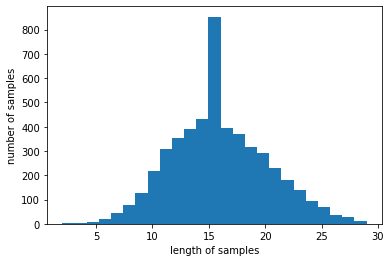

In [162]:
print('트윗의 최대 길이 : %d' % max(len(l) for l in x_data))
print('트윗의 평균 길이 : %f' % (sum(map(len, x_data))/len(x_data)))
print('\n')
plt.hist([len(s) for s in x_data], bins=25)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [163]:
max_len = 29
data = pad_sequences(x_data, maxlen=max_len)
data.shape

(5000, 29)

In [164]:
train_df.head()

,Tweet,0,1,2,3,4,5,6,7,8,9,10
0,NO JOKE I WILL HOP ON A PLANE RN! (Well after ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,BanMediaHouse whose is responsible for spreadi...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Im waiting for someone to say to me that all t...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,He is a liar. Proven day night. Time again. Li...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,"NEW: U.S. CoronaVirus death toll reaches 4,000...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [165]:
y = train_df['0']
y.head()

0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float64

In [166]:
x_test = data[n_of_train:] #x_data 데이터 중에서 뒤의 1000 개의 데이터만 저장
y_test = np.array(y[n_of_train:]) #y 데이터 중에서 뒤의 1000 개의 데이터만 저장
x_train = data[:n_of_train] #x_data 데이터 중에서 앞의 4000개의 데이터만 저장
y_train = np.array(y[:n_of_train]) #y 데이터 중에서 앞의 4000개의 데이터만 저장

In [167]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(4000, 29) (4000,)
(1000, 29) (1000,)


In [168]:
print(x_train[:1], '\n',y_train[:1])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   50   45    5   47 2167   21    6 2773  457  183  111   10
   219]] 
 [1.]


In [169]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
50/50 [==============================] - 2s 16ms/step - loss: 0.5676 - acc: 0.7494 - val_loss: 0.5451 - val_acc: 0.7675
Epoch 2/4
50/50 [==============================] - 1s 11ms/step - loss: 0.4986 - acc: 0.7678 - val_loss: 0.5567 - val_acc: 0.7600
Epoch 3/4
50/50 [==============================] - 1s 10ms/step - loss: 0.3687 - acc: 0.8381 - val_loss: 0.5963 - val_acc: 0.7075
Epoch 4/4
50/50 [==============================] - 1s 10ms/step - loss: 0.2249 - acc: 0.9297 - val_loss: 0.6501 - val_acc: 0.7225


In [170]:
#model.predict()

In [171]:
test_seq = tokenizer.texts_to_sequences(test_df['Tweet'])
test = pad_sequences(test_seq, maxlen=max_len)
test.shape

(2500, 29)

In [172]:
res = model.predict(test)
answer = pd.DataFrame(res, columns = ['0'])
answer['0'] = answer['0'].apply(lambda x : 1 if x >= 0.5 else 0)
answer

,0
0,0
1,0
2,0
3,0
4,0
...,...
2495,0
2496,0
2497,0
2498,0


In [196]:
from tensorflow.keras.callbacks import EarlyStopping
def RNN_df() :
    df = pd.DataFrame()
    test_seq = tokenizer.texts_to_sequences(test_df['Tweet'])
    test = pad_sequences(test_seq, maxlen=max_len)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

    for sentiment in target :
        y = train_df[sentiment]
        x_test = data[n_of_train : ]
        x_train = data[:n_of_train]
        y_test = np.array(y[n_of_train:])
        y_train = np.array(y[:n_of_train])
        model = Sequential()
        model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
        model.add(SimpleRNN(32)) # RNN 셀의 hidden_size는 32
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
        model.fit(x_train, y_train, epochs=4, batch_size=64, validation_split=0.2, verbose = 0,
                  callbacks = [es])
        res = model.predict(test)
        answer = pd.DataFrame(res, columns = [sentiment])
        df[sentiment] = answer[sentiment].apply(lambda x : 1 if x >= 0.4 else 0)
        print( sentiment ,  ' 완료')
    
    return df

In [197]:
rnn_1 = RNN_df()
rnn_1

0  완료
1  완료
2  완료
3  완료
4  완료
5  완료
6  완료
7  완료
8  완료
9  완료
10  완료


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,1,0,0
2496,0,0,0,0,0,0,0,0,0,0,1
2497,0,0,0,1,0,0,1,0,0,0,0
2498,0,0,0,0,0,0,0,0,0,0,1


In [198]:
for i in target :
    print(rnn_1[i].value_counts())
#rnn_1['0'].value_counts()

0    2029
1     471
Name: 0, dtype: int64
0    2446
1      54
Name: 1, dtype: int64
0    2467
1      33
Name: 2, dtype: int64
0    2194
1     306
Name: 3, dtype: int64
0    2067
1     433
Name: 4, dtype: int64
0    1758
1     742
Name: 5, dtype: int64
0    1940
1     560
Name: 6, dtype: int64
0    2485
1      15
Name: 7, dtype: int64
0    2151
1     349
Name: 8, dtype: int64
0    2139
1     361
Name: 9, dtype: int64
0    1505
1     995
Name: 10, dtype: int64


In [200]:
submission = test_df.drop(['Tweet'], axis=1)
submission['Labels'] = 0
submission.head()

,ID,Labels
0,5001,0
1,5002,0
2,5003,0
3,5004,0
4,5005,0


In [201]:
for row in range(2500) :
    one_row = []
    for cat in target :
        if int(rnn_1[row:row+1][cat].values) == 1 :
            one_row.append(cat)
    submission.Labels[row] = ' '.join(one_row)

In [202]:
submission.head(30)

,ID,Labels
0,5001,10
1,5002,8
2,5003,10
3,5004,10
4,5005,10
5,5006,0 8 10
6,5007,6 10
7,5008,6 9 10
8,5009,
9,5010,0 10


In [205]:
submission[submission['Labels'] == '']['Labels'] = '10'

In [199]:
sub_half = submission

,ID,Labels
8,5009,
23,5024,
33,5034,
35,5036,
38,5039,
...,...,...
2461,7462,
2467,7468,
2485,7486,
2486,7487,


In [ ]:
# 0.5 일때 결측값 492개
# 0.4 일때 결측값 256개

,Tweet,0,1,2,3,4,5,6,7,8,9,10


## NLTK

In [32]:
!pip install nltk

In [34]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
sentence = 'I love you so much'
words = nltk.word_tokenize(sentence)
words

['I', 'love', 'you', 'so', 'much']

In [38]:
from keras.preprocessing.text import text_to_word_sequence
senetence = "you're a good boy who I've seen"
words = text_to_word_sequence(senetence)
words

["you're", 'a', 'good', 'boy', 'who', "i've", 'seen']